<img src="https://raw.githubusercontent.com/tamedia-ddj/brennpunkt_bauernhof_public/master/files/Bauernhof_Logo.jpg">

# Brennpunkt Bauernhof
## Analyse des Datenbestandes zu den Direktzahlungen 2014 bis 2017

Ein Rechercheteam von Tamedia veröffentlich diese Woche eine Serie von Artikeln zur Landwirtschaft. Es wurden dazu Daten über Direktzahlung sowie über 600 Strafurteile gegen Landwirte ausgewertet.

In den folgenden Notebooks sind die relevanten Ausschnitte der Analyse dokumentiert. Der beiliegende Datensatz wurde zur Wahrung des Datenschutzes gekürzt und verändert (Gemeinde, Kantone und Zahlenwerte wurden willkürlich vertauscht).




1. **Datenvorbereitung**
2. Kürzungen
    * Methodik: [Github](https://github.com/tamedia-ddj/brennpunkt_bauernhof_public/blob/master/1_Kuerzungen.ipynb)
    * Artikel:
        * [Skandalöse Zustände auf Schweizer Bauernhöfen](https://www.tagesanzeiger.ch/schweiz/brennpunkt-bauernhof/skandaloese-zustaende-auf-schweizer-bauernhoefen/story/17687029)
        * [Sogar Tierquäler erhalten Subventionen](https://www.tagesanzeiger.ch/schweiz/brennpunkt-bauernhof/bauern-erhalten-subventionen-trotz-leidender-tiere/story/19918846)
3. Kontrollen
	* Artikel:
		* [Zu wenig Kontrollen: Tierquäler bleiben unentdeckt](https://www.tagesanzeiger.ch/schweiz/brennpunkt-bauernhof/zu-wenig-geld-fuer-tierkontrollen/story/12827795)
        * [Der Bauern-Sherlock](https://www.tagesanzeiger.ch/schweiz/brennpunkt-bauernhof/wie-ein-ermittler-mit-videobeweisen-landwirte-ueberfuehrt/story/16595684)
4. Direktzahlungsbeträge
    * Methodik: [Github](https://github.com/tamedia-ddj/brennpunkt_bauernhof_public/blob/master/2_Betraege.ipynb)
    * Artikel:
        * [«Das war für uns wie ein Lottosechser»](https://www.tagesanzeiger.ch/schweiz/brennpunkt-bauernhof/welche-bauern-am-meisten-erhalten/story/25753875)


Quelle des Datensatzes: BLW

---

### Notebook 1 - Vorbereitung
#### Bereinigung und Vorbereitung des Datensatzes zur späteren Untersuchung

---

#### Load Packages

In [32]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

#### Import data

In [47]:
# read excel-file
data = pd.read_excel("data_input/Analyse_mod.xlsx")
# drop unused/wrong columns
data = data.drop(columns=["Subvention_Gesamt", "Column1"])
# recalculate subsidies
data["Subvention_Gesamt"] = data.DZ_BEITRAG_BUND + data.SOEMMERUNGSBEITRAG_BUND
# save data for further analysis
data.to_pickle("files/data_mod.pkl")

---

#### create fixed list of municipalities and their corresponding cantons


In [6]:
messy_gde = data[["GDE_GEMEINDE_NR", "GDE_NAME", "ABJ_KANTON", "BETRIEBSNUMMER_ZUFALL"]].groupby(["GDE_GEMEINDE_NR", "GDE_NAME", "ABJ_KANTON"]).count().reset_index()
messy_gde = messy_gde[messy_gde.GDE_GEMEINDE_NR != 0]

In [11]:
dupl_gdes = pd.DataFrame(messy_gde.GDE_GEMEINDE_NR.value_counts())
dupl_gdes = dupl_gdes[dupl_gdes.GDE_GEMEINDE_NR > 1]

In [12]:
clean_gde = messy_gde
for index, row in dupl_gdes.iterrows():
    min_val = clean_gde[(clean_gde.GDE_GEMEINDE_NR == index)].BETRIEBSNUMMER_ZUFALL.min()
    clean_gde = clean_gde[clean_gde.index != clean_gde[(clean_gde.GDE_GEMEINDE_NR == index) & (clean_gde.BETRIEBSNUMMER_ZUFALL == min_val)].index[0]]    

In [45]:
clean_gde[["GDE_GEMEINDE_NR", "GDE_NAME", "ABJ_KANTON"]].reset_index(drop=True).to_pickle("files/gemeinden_bereinigt.pkl")
clean_gde = pd.read_pickle("files/gemeinden_bereinigt.pkl")


---

#### basic visualizations

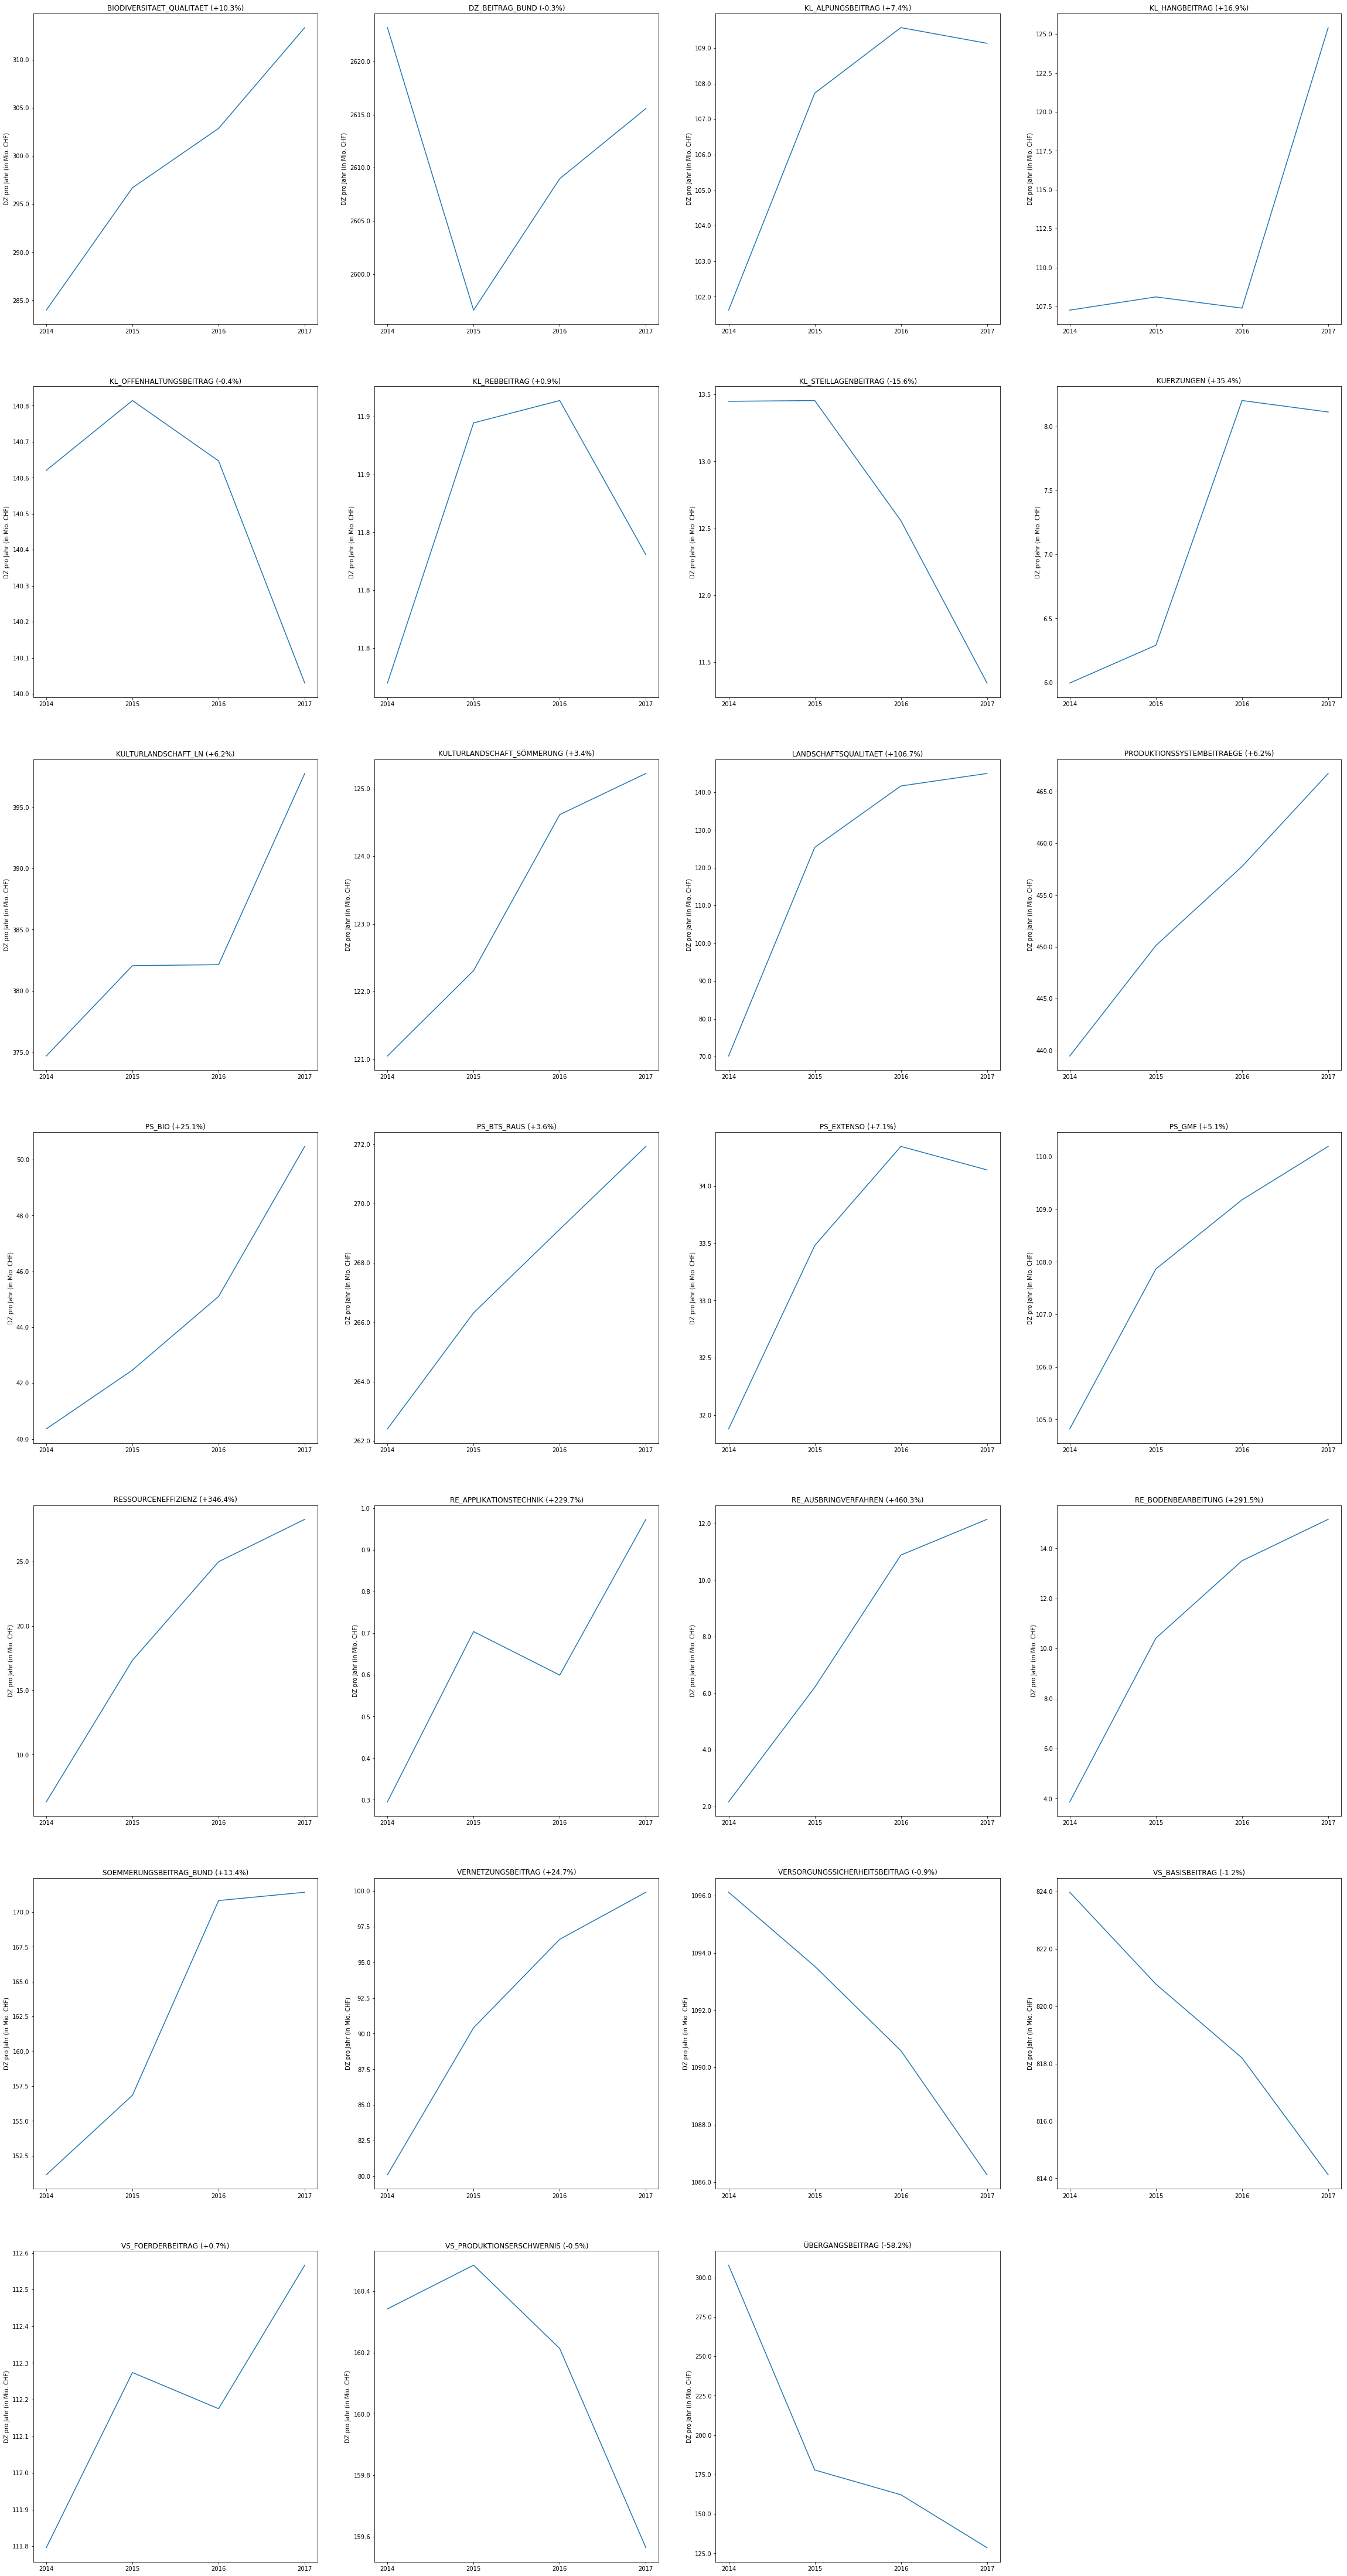

In [33]:
plt.figure(figsize=(40,80))

width=4
height=7

def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{:2.1f}'.format(x / 1000000)
    return s

for idx, title in enumerate(['BIODIVERSITAET_QUALITAET', 'DZ_BEITRAG_BUND', 'KL_ALPUNGSBEITRAG', 'KL_HANGBEITRAG',
       'KL_OFFENHALTUNGSBEITRAG', 'KL_REBBEITRAG', 'KL_STEILLAGENBEITRAG',
       'KUERZUNGEN', 'KULTURLANDSCHAFT_LN', 'KULTURLANDSCHAFT_SÖMMERUNG',
       'LANDSCHAFTSQUALITAET', 'PRODUKTIONSSYSTEMBEITRAEGE', 'PS_BIO',
       'PS_BTS_RAUS', 'PS_EXTENSO', 'PS_GMF', 'RESSOURCENEFFIZIENZ',
       'RE_APPLIKATIONSTECHNIK', 'RE_AUSBRINGVERFAHREN', 'RE_BODENBEARBEITUNG',
       'SOEMMERUNGSBEITRAG_BUND', 'VERNETZUNGSBEITRAG',
       'VERSORGUNGSSICHERHEITSBEITRAG', 'VS_BASISBEITRAG', 'VS_FOERDERBEITRAG',
       'VS_PRODUKTIONSERSCHWERNIS', 'ÜBERGANGSBEITRAG']):
    
    ax = plt.subplot(height, width, idx + 1)
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(numfmt))
    ax.set_ylabel('DZ pro Jahr (in Mio. CHF)')
    plt.title("{} ({:+1.1f}%)".format(title, (100/data[title].groupby(data['JAHR']).sum().iloc[0]*data[title].groupby(data['JAHR']).sum().iloc[3])-100))
    plt.xticks(np.arange(2014, 2018))
    ax.plot(data[title].groupby(data['JAHR']).sum())

plt.show()

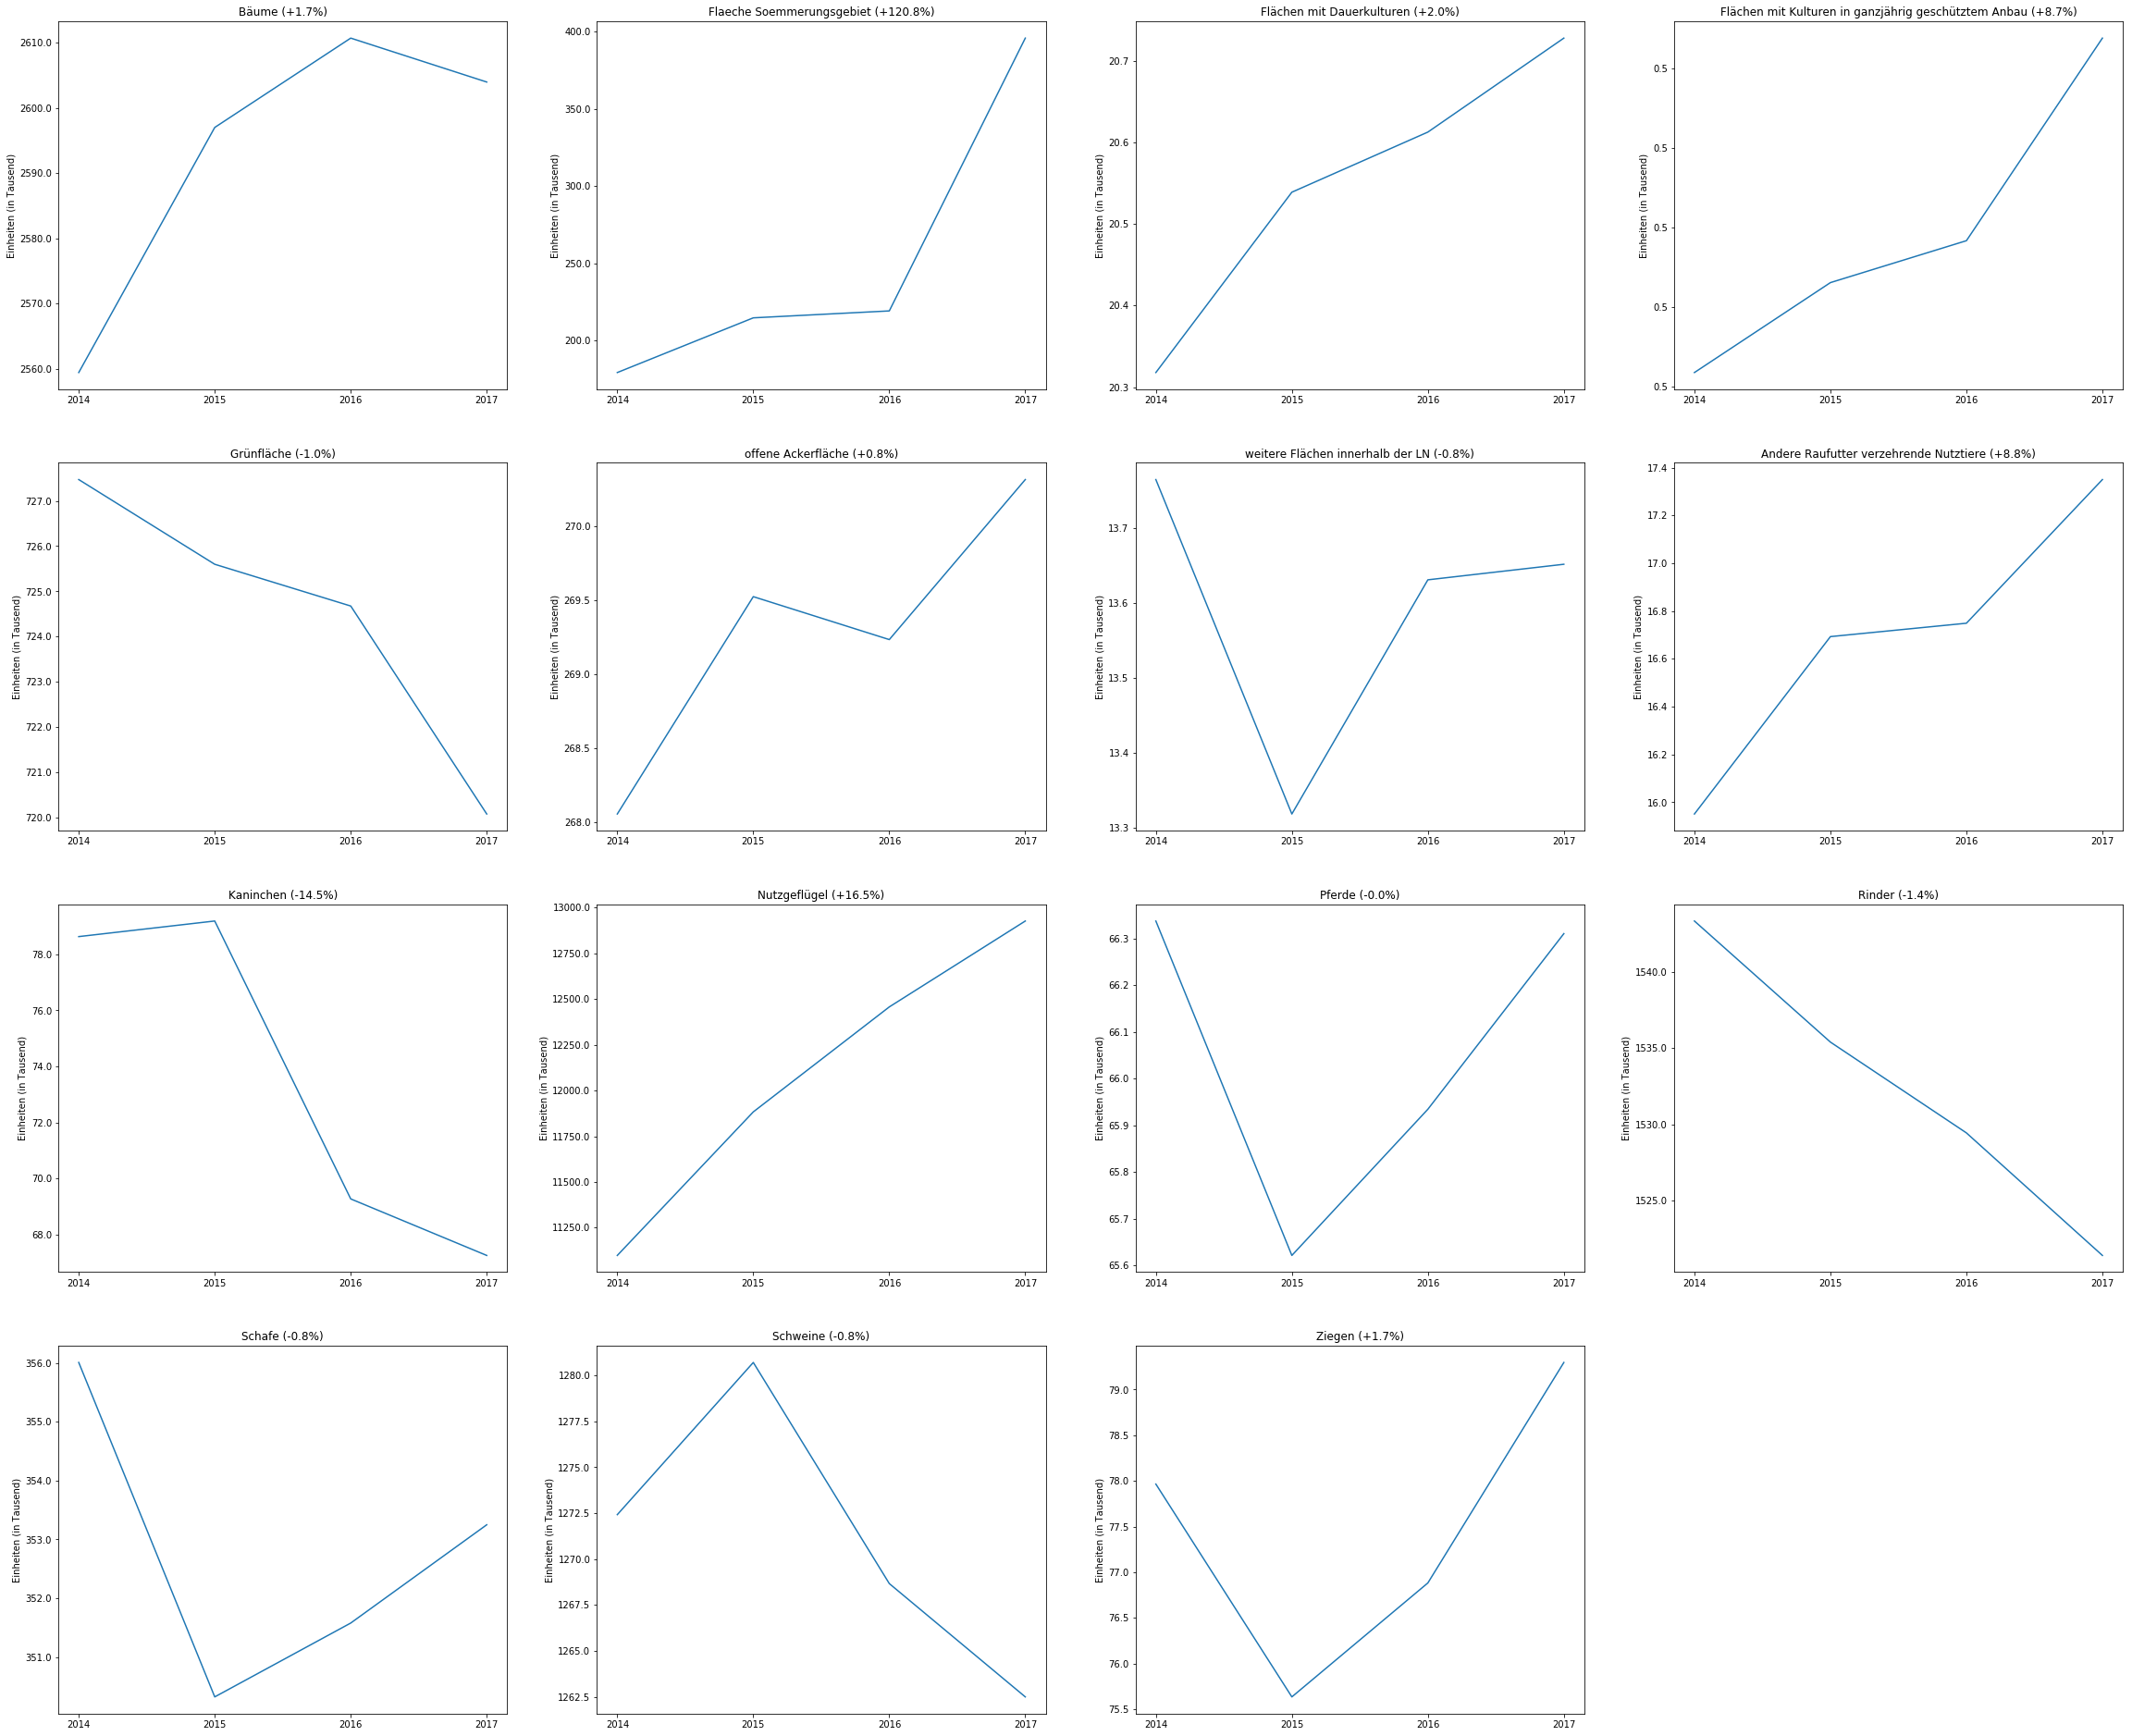

In [34]:
plt.figure(figsize=(40,60))

width=4
height=7

def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{:2.1f}'.format(x / 1000)
    return s

for idx, title in enumerate(['Bäume',
       'Flaeche Soemmerungsgebiet', 'Flächen mit Dauerkulturen',
       'Flächen mit Kulturen in ganzjährig geschütztem Anbau',
       'Grünfläche', 'offene Ackerfläche',
       'weitere Flächen innerhalb der LN',
       'Andere Raufutter verzehrende Nutztiere', 'Kaninchen',
       'Nutzgeflügel', 'Pferde', 'Rinder', 'Schafe', 'Schweine', 'Ziegen']):
    
    ax = plt.subplot(height, width, idx + 1)
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(numfmt))
    ax.set_ylabel('Einheiten (in Tausend)')
    plt.title("{} ({:+1.1f}%)".format(title, (100/data[title].groupby(data['JAHR']).sum().iloc[0]*data[title].groupby(data['JAHR']).sum().iloc[3])-100))
    plt.xticks(np.arange(2014, 2018))
    ax.plot(data[title].groupby(data['JAHR']).sum())

plt.show()

[Text(0, 0.5, 'Anzahl Betriebe'), Text(0.5, 0, 'Höhe der Direktzahlungen')]

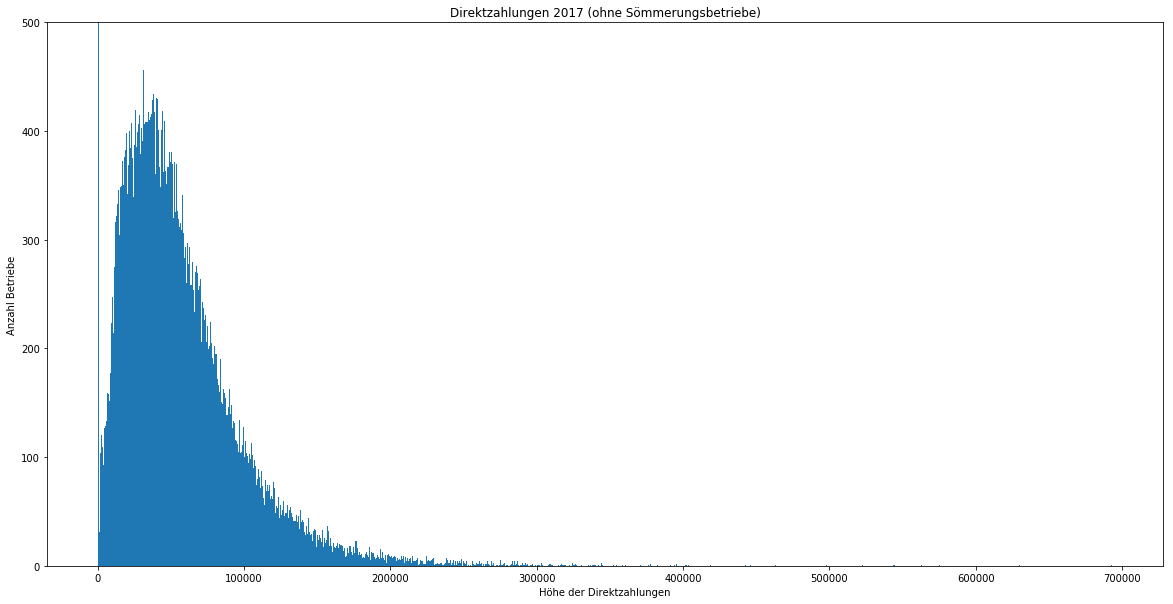

In [35]:
ax = data[data.JAHR == 2017].DZ_BEITRAG_BUND.plot.hist(bins=1000, figsize=(20, 10), ylim=(0,500))
ax.set_title('Direktzahlungen 2017 (ohne Sömmerungsbetriebe)')
ax.set(xlabel="Höhe der Direktzahlungen", ylabel="Anzahl Betriebe")